In [ ]:
#모듈 import - tensorflow & keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.models import load_model
#callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
#optimizers
from tensorflow.keras.optimizers import SGD,Adam

#모델 성능 평가 
from sklearn.metrics import accuracy_score, confusion_matrix

#모듈 import - data processing
import cv2
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder

#모듈 import - others 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
import time

from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import *
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd "/content/drive/MyDrive/subssion_folder/OCT_Retinal/Datas"
!unzip -qq "/content/drive/MyDrive/subssion_folder/OCT_Retinal/Datas/OCT_small.zip"

In [ ]:
root_dir = "/content/OCT_small/"
train_dir = "/content/OCT_samll/train"
test_dir = "/content/OCT_small/test"
validation_dir = "/content/OCT_small/validation"

In [ ]:
# 데이터셋 생성하기.
dataset = {
    "img_path" : [],
    "class" : [],
    "split" : []
}

for classes in os.listdir(root_dir):
  for disease in os.listdir(root_dir + "/" + classes):
    #print(classes, "/", disease)
    for image in glob.glob(root_dir+"/"+classes+"/"+disease+"/*.jpeg"):
      dataset["img_path"].append(image)
      dataset["class"].append(disease)
      dataset["split"].append(classes)
dataset = pd.DataFrame(dataset)
dataset

,img_path,class,split
0,/content/OCT_small//test/NORMAL/NORMAL-949285-...,NORMAL,test
1,/content/OCT_small//test/NORMAL/NORMAL-98720-2...,NORMAL,test
2,/content/OCT_small//test/NORMAL/NORMAL-9055342...,NORMAL,test
3,/content/OCT_small//test/NORMAL/NORMAL-724932-...,NORMAL,test
4,/content/OCT_small//test/NORMAL/NORMAL-900316-...,NORMAL,test
...,...,...,...
7124,/content/OCT_small//train/DME/DME-9932957-4.jpeg,DME,train
7125,/content/OCT_small//train/DME/DME-9500659-2.jpeg,DME,train
7126,/content/OCT_small//train/DME/DME-4669768-1.jpeg,DME,train
7127,/content/OCT_small//train/DME/DME-9011183-3.jpeg,DME,train


train data frame len:  4995
test data frame len :  1425
validation data frame len :  709


Text(0.5, 1.0, 'Validation Dataset')

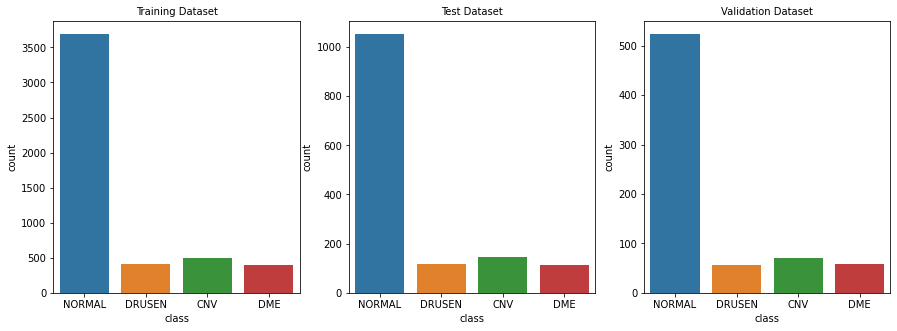

In [ ]:
#데이터 분포 확인하기
train_dataframe = dataset[dataset["split"] == "train"] 
test_dataframe = dataset[dataset["split"] == "test"] 
validation_dataframe = dataset[dataset["split"] == "validation"] 
print("train data frame len: ", len(train_dataframe))
print("test data frame len : ", len(test_dataframe))
print("validation data frame len : ", len(validation_dataframe))

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_dataframe["class"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_dataframe["class"])
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=validation_dataframe["class"])
plt.title("Validation Dataset", size=10)

밸런스 맞추기 전 (train, test, validation):  4995 1425 709
밸런스 맞추기 후 (train, test, validation) :  1765 504 251


Text(0.5, 1.0, 'Validation Dataset')

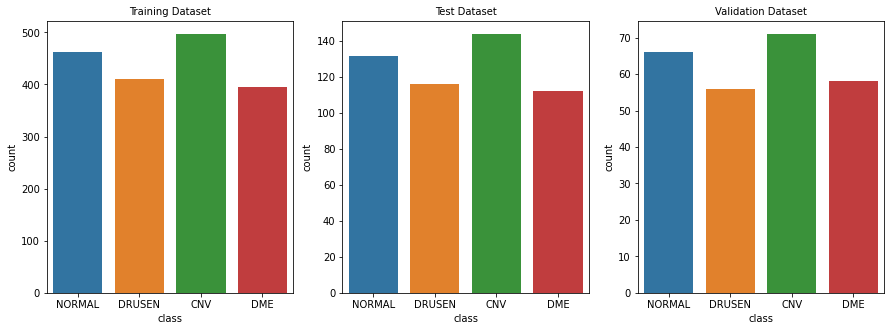

In [ ]:
# NORMAL Class 무작위 표본표출로 전체 Class 밸런스 맞추기.
print("밸런스 맞추기 전 (train, test, validation): ", len(train_dataframe), len(test_dataframe), len(validation_dataframe))
def makedf(df) : 
  samples = df[df["class"] == "NORMAL"].sample(frac=0.125, random_state=77)
  others = df[df["class"] != "NORMAL"]
  result = pd.concat([samples, others], axis=0)
  
  return result
train_dataframe = makedf(train_dataframe)
test_dataframe = makedf(test_dataframe)
validation_dataframe = makedf(validation_dataframe)  
print("밸런스 맞추기 후 (train, test, validation) : ", len(train_dataframe), len(test_dataframe), len(validation_dataframe))


plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train_dataframe["class"])
plt.title("Training Dataset", size=10)
plt.subplot(1, 3, 2)
sns.countplot(x=test_dataframe["class"])
plt.title("Test Dataset", size=10)
plt.subplot(1, 3, 3)
sns.countplot(x=validation_dataframe["class"])
plt.title("Validation Dataset", size=10)


In [ ]:
X_train, y_train = train_dataframe["img_path"], train_dataframe["class"]
X_test, y_test = test_dataframe["img_path"], test_dataframe["class"]
X_validation, y_validation = validation_dataframe["img_path"], validation_dataframe["class"]

In [ ]:
#unique value extract
for name in list(train_dataframe["class"].unique()):
  print("train unique", name, len(train_dataframe[train_dataframe["class"] == name]))

for name in list(test_dataframe["class"].unique()):
  print("test unique",name, len(test_dataframe[test_dataframe["class"] == name]))

for name in list(validation_dataframe["class"].unique()):
  print("validation unique",name, len(validation_dataframe[validation_dataframe["class"] == name]))



train unique NORMAL 462
train unique DRUSEN 410
train unique CNV 497
train unique DME 396
test unique NORMAL 132
test unique DRUSEN 116
test unique CNV 144
test unique DME 112
validation unique NORMAL 66
validation unique DRUSEN 56
validation unique CNV 71
validation unique DME 58


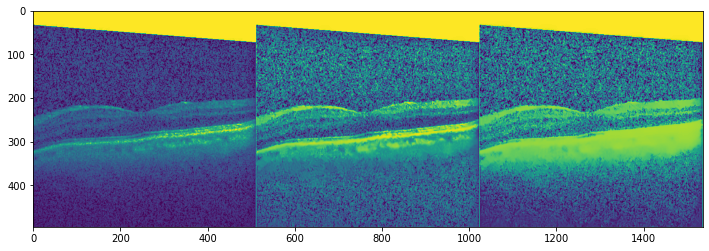

In [ ]:
### data sampling & view

sample = random.choice(dataset["img_path"])
#image = mpimg.imread(sample)
img = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)
hist1 = cv2.calcHist(img, [0], None, [256], [0, 256])
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(img)
he = cv2.equalizeHist(img)

img2 = cv2.fastNlMeansDenoising(cl, None, 16, 7,21)
img3 = cv2.fastNlMeansDenoising(he, None, 16, 7,21)
res = np.hstack((img,img2, img3)) 

plt.figure(figsize=(12, 5))
plt.imshow(res)
plt.show()


In [ ]:
### moments 이미지 변환

#def norm_digit(img):
def norm_convert(img):
    m = cv2.moments(img)
    cx = m['m10'] / m['m00']
    cy = m['m01'] / m['m00']
    h, w = img.shape[:2]
    aff = np.array([[1, 0, w/2 - cx], [0, 1, h/2 - cy]], dtype=np.float32)
    dst = cv2.warpAffine(img, aff, (0, 0))
    return dst

In [ ]:
def img_preprocess(imgs):
  images = []
  bar_total = tqdm(imgs)
  for file in bar_total:
          img = cv2.imread(file, 0)
          img = np.where(img == 255, 0, img)
          img = norm_convert(img)
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          cl1 = clahe.apply(img)
          
          ## inception resnetv2 input
          #images.append(resize(img, (299,299,3)))       
          images.append(resize(cl1,(299,299,3)))

  images = np.array(images)
  return images

In [ ]:
X_train = img_preprocess(X_train)
X_test = img_preprocess(X_test)
X_validation = img_preprocess(X_validation)

  0%|          | 0/1765 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

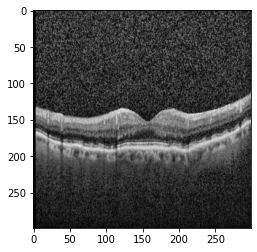

In [ ]:
#X_train random view
plt.imshow(X_train[random.choice(range(len(X_train)))])

In [ ]:
# y label encoder
from sklearn.preprocessing import LabelEncoder

def makelabel(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  labels_encoded = encoder.transform(labels)
  labels_encoded[:3], encoder.classes_
  return labels_encoded
  
y_train = makelabel(y_train)
y_test = makelabel(y_test)
y_validation  = makelabel(y_validation)

In [ ]:
#ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode = "nearest"
)
test_datagen = ImageDataGenerator()

train_augment = datagen.flow(
    x=X_train, y=y_train, batch_size=5, 
    shuffle=True, sample_weight=None, seed=13,
    save_to_dir=None)

test_augment = test_datagen.flow(
    x=X_test, y=y_test, batch_size=1, 
    shuffle=True, sample_weight=None, seed=13,
    save_to_dir=None)


In [ ]:
#InceptionV3(Googlenet) : def img_preprocess에서 resize 128,128,3 설정
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

inp = layers.Input(shape=(128, 128, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=X_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(4, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(4, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(4, activation='softmax')(x)

In [ ]:
### Resnet50 def img_preprocess에서 resize 224,224,3 설정
base = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights=None, pooling="max")
input = tf.keras.layers.Input(shape=(224, 224, 3))
base = base(input)
out = tf.keras.layers.Dense(4, activation="softmax")(base)
model = tf.keras.models.Model(input, out)
model.summary()

In [ ]:
### InceptinoResnetV2 Model def img_preprocess에서 resize 299,299,3 설정
base =  tf.keras.applications.InceptionResNetV2(include_top=True, weights='imagenet',input_shape=(299,299,3), pooling='max')
input = tf.keras.layers.Input(shape=(299, 299, 3))
base = base(input)
out = tf.keras.layers.Dense(4, activation="softmax")(base)
model = tf.keras.models.Model(input, out)
model.summary()

225209952/225209952 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 1000)             55873736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 4)                 4004      
                                                                 
Total params: 55,877,740
Trainable params: 55,817,196
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizers,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 1000)             55873736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 4)                 4004      
                                                                 
Total params: 55,877,740
Trainable params: 55,817,196
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=20, 
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,  
    )     

history = model.fit(train_augment, 
                    validation_data = test_augment,
                    batch_size=64, 
                    steps_per_epoch = len(X_train)/16,
                    epochs=550,
                    callbacks=[early_stopping,rlr_cb]
                    )

Epoch 1/150
110/110 [==============================] - 73s 402ms/step - loss: 1.3688 - accuracy: 0.3604 - val_loss: 1.3848 - val_accuracy: 0.3036
Epoch 2/150
110/110 [==============================] - 41s 373ms/step - loss: 1.3427 - accuracy: 0.4324 - val_loss: 1.3884 - val_accuracy: 0.2857
Epoch 3/150
110/110 [==============================] - 41s 372ms/step - loss: 1.3090 - accuracy: 0.4505 - val_loss: 1.4055 - val_accuracy: 0.2639
Epoch 4/150
110/110 [==============================] - 41s 372ms/step - loss: 1.2886 - accuracy: 0.4595 - val_loss: 1.4113 - val_accuracy: 0.2857
Epoch 5/150
110/110 [==============================] - 41s 370ms/step - loss: 1.2626 - accuracy: 0.4721 - val_loss: 1.3058 - val_accuracy: 0.4306
Epoch 6/150
110/110 [==============================] - 41s 371ms/step - loss: 1.3424 - accuracy: 0.3766 - val_loss: 1.4215 - val_accuracy: 0.2857
Epoch 7/150
110/110 [==============================] - 41s 370ms/step - loss: 1.3639 - accuracy: 0.3477 - val_loss: 1.4173 -

KeyboardInterrupt: ignored

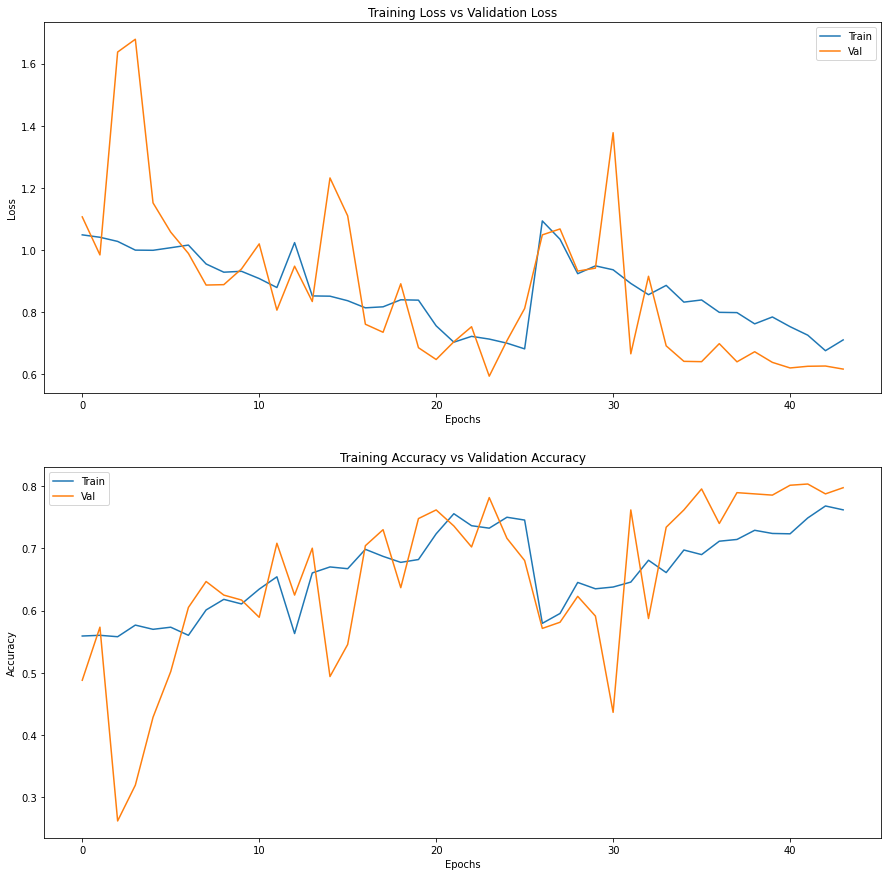

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
#evaluate
model.evaluate(X_test, y_test)

56/56 [==============================] - 21s 331ms/step - loss: 0.5462 - accuracy: 0.8334


[0.5461730360984802, 0.8334277868270874]

In [ ]:
pred = model.predict(X_validation)
pred = np.argmax(pred, axis=1)
accuracy_score(y_validation , pred), confusion_matrix(y_validation, pred)

8/8 [==============================] - 2s 322ms/step


(0.7928286852589641, array([[57,  1,  6,  7],
        [ 4, 47,  0,  7],
        [ 0,  0, 33, 23],
        [ 0,  1,  3, 62]]))